In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow import keras
# Load dữ liệu từ file CSV (ví dụ)
df = pd.read_csv('VCB.csv')
df1=df.reset_index()['Price']
df1.describe

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]


# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],30, 1)
X_test = X_test.reshape(X_test.shape[0],30, 1)


In [2]:
def Seq2SeqModel(T = 30, NFeature = 1):

  encoder_inputs = tf.keras.layers.Input(shape=(T, NFeature))

  encoder_cell = tf.keras.layers.LSTM(128, return_state=True, name='encoder_layer')

  encoder_outputs_and_states = encoder_cell(encoder_inputs)

  encoder_states = encoder_outputs_and_states[1:] # only keep the states

  decoder_inputs = keras.layers.Input(shape=(None, 1), name='decoder_input') #### <=== must be 1

  decoder_cell = tf.keras.layers.LSTM(128, return_state=True, return_sequences=True, name='decoder_layer')

  decoder_outputs_and_states = decoder_cell(decoder_inputs, initial_state=encoder_states)

  decoder_outputs = decoder_outputs_and_states[0] # only keep the output sequence
  decoder_dense = keras.layers.Dense(1)

  decoder_outputs = decoder_dense(decoder_outputs)

  model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
  model.compile(optimizer='adam',
                loss='mse')

  return model
model = Seq2SeqModel(30, 1)
model.fit(
        [X_train, np.zeros((X_train.shape[0], 1, 1))],
        y_train.reshape(-1, 1, 1),
        epochs = 100,
        batch_size= 256,
      )





Epoch 1/100

8/8 [==============================] - 3s 55ms/step - loss: 0.0544
Epoch 2/100
8/8 [==============================] - 0s 53ms/step - loss: 0.0076
Epoch 3/100
8/8 [==============================] - 0s 48ms/step - loss: 0.0046
Epoch 4/100
8/8 [==============================] - 0s 45ms/step - loss: 0.0023
Epoch 5/100
8/8 [==============================] - 0s 61ms/step - loss: 0.0011
Epoch 6/100
8/8 [==============================] - 0s 45ms/step - loss: 5.0094e-04
Epoch 7/100
8/8 [==============================] - 0s 45ms/step - loss: 3.7852e-04
Epoch 8/100
8/8 [==============================] - 0s 47ms/step - loss: 3.2476e-04
Epoch 9/100
8/8 [==============================] - 0s 41ms/step - loss: 2.9832e-04
Epoch 10/100
8/8 [==============================] - 0s 42ms/step - loss: 2.8366e-04
Epoch 11/100
8/8 [==============================] - 0s 45ms/step - loss: 2.8316e-04
Epoch 12/100
8/8 [==============================] - 0s 45ms/step - loss: 2.7972e-04
Epoch 13/100
8/8 [

8/8 [==============================] - 0s 59ms/step - loss: 1.9556e-04
Epoch 92/100
8/8 [==============================] - 0s 60ms/step - loss: 2.0012e-04
Epoch 93/100
8/8 [==============================] - 0s 59ms/step - loss: 1.9414e-04
Epoch 94/100
8/8 [==============================] - 0s 56ms/step - loss: 1.9242e-04
Epoch 95/100
8/8 [==============================] - 0s 61ms/step - loss: 1.9017e-04
Epoch 96/100
8/8 [==============================] - 0s 57ms/step - loss: 1.9121e-04
Epoch 97/100
8/8 [==============================] - 0s 56ms/step - loss: 1.9188e-04
Epoch 98/100
8/8 [==============================] - 0s 54ms/step - loss: 1.9575e-04
Epoch 99/100
8/8 [==============================] - 0s 56ms/step - loss: 2.0616e-04
Epoch 100/100
8/8 [==============================] - 0s 54ms/step - loss: 1.8860e-04


In [3]:
# 10. Dự báo dữ liệu test, val
y_pred_train = model.predict([X_train, np.zeros((X_train.shape[0],1,1))])
y_pred_test = model.predict([X_test, np.zeros((X_test.shape[0],1,1))])

# 11. Chuẩn hóa dữ liệu y_pred
# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(y_train.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(y_test.reshape(1, -1))



15/15 [==============================] - 0s 6ms/step


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, mean_squared_log_error
# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100
# Tính toán RMSE, MAPE, MDA trên tập test
test_score_rmse=np.sqrt(mean_squared_error(y_true_test, pred_test))
test_score_mape=mean_absolute_percentage_error(y_true_test, pred_test) * 100
test_score_mda=calculate_mda(y_true_test, pred_test)
msle = mean_squared_log_error(y_true_test, pred_test)
print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')
print('MSLE trên tập test là:', msle)

RMSE trên tập test là: 2068.817592275679
MAPE trên tập test là: 1.765566068867502 %
MDA trên tập test là: 42.73504273504273 %
MSLE trên tập test là: 0.0006068440310337336


1/1 [==============================] - 0s 16ms/step


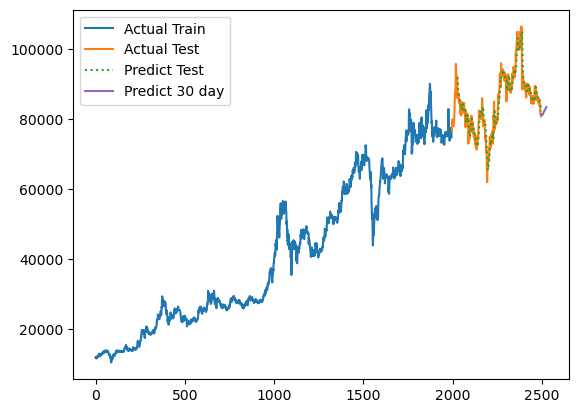

In [9]:
# Predict Next 30 days
npred = 30
i = 0
pred_list = []
input = df1[-30:]

while i < npred:
  pred = model.predict([input.reshape(1, -1, 1), np.zeros((1,1,1))])
  pred_list.append(pred)

  input = np.concatenate([input.squeeze(), pred.reshape(1, )])
  input = input[1:]
  i += 1

pred_list = np.array(pred_list)
pred_list = scaler.inverse_transform(pred_list.reshape(1, -1))



color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
from matplotlib import pyplot as plt
# plt.figure(figsize=(12, 4))

# train
train_range = range(0, len(y_true_train.squeeze()))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Actual Train")
# plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
# test_range = range(len(y_true_train.squeeze()),len(y_true_train.squeeze()) + len(y_true_test.squeeze()))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Actual Test")
test_data_index = pd.RangeIndex(start=train_size+31, stop=len(df1), step=1)
plt.plot(test_data_index, pred_test.squeeze(), label="Predict Test", linestyle="dotted")


#30 days
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(prediect_data_index, pred_list.squeeze(), label="Predict 30 day",color = color_palette[4])

# # Dự đoán 30 điểm tiếp theo
# prediect_data_index = range(len(df1), len(df1) + 30)
# plt.plot(prediect_data_index, pred_list.squeeze(), label="Predict 30 day")
plt.legend()
plt.show()


In [6]:
pred_list

array([[81362.836, 81221.8  , 81147.65 , 81123.64 , 81137.54 , 81179.8  ,
        81242.38 , 81319.73 , 81407.48 , 81502.57 , 81602.195, 81704.79 ,
        81808.93 , 81913.83 , 82018.72 , 82123.125, 82226.695, 82329.6  ,
        82431.47 , 82532.49 , 82632.484, 82731.53 , 82829.48 , 82926.47 ,
        83022.375, 83117.586, 83211.84 , 83305.08 , 83397.35 , 83488.73 ]],
      dtype=float32)